# Machine Learning Unit - Assignment 1

<h3>Effective BoW representation with a binary classifier pipeline

<h4>Chris Rickard</h4>

<p>In this notebook I take a dataset of Amazon product reviews, Yelp restaurant reviews, and IMDB film reviews and apply sentiment classification to determine if a review is positive or negative. Applying the below techniques: </p>
<ul>
<li> Stemming</li>
<li> Stop words</li>
<li> TF-IDF</li>
<li> n-grams</li>
<li> Logistic Regression </li>
</ul>

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# set random seed
np.random.seed(108)

## Task 1 – Data Loading and data preparation (10%)

### Load Data

Import the four datasets using into DataFrames and numpy arrays

In [2]:
# Column names
X_columns = ['website_name', 'text']
y_columns = ['is_positive_sentiment']

# ensure reviews are imported as StringDtype as recomended by pandas
# https://pandas.pydata.org/docs/user_guide/text.html
dtypes = {'website_name': 'category', 'text': pd.StringDtype()}


# import features as a DataFrame and labels as np array
X_train = pd.read_csv('Dataset/X_train.csv', names=X_columns, dtype=dtypes)
y_train = pd.read_csv('Dataset/y_train.csv', names=y_columns, dtype=dtypes).values.ravel()

X_test = pd.read_csv('Dataset/X_test.csv', names=X_columns, dtype=dtypes)
y_test = pd.read_csv('Dataset/y_test.csv', names=y_columns, dtype=dtypes).values.ravel()

### Data Cleaning

Ensure all review text is lower case and remove punctuation, then stem text to the root of the word 

In [3]:
# import stemmer
from nltk.stem import SnowballStemmer
import re

# initialize stemmer
stemmer = SnowballStemmer('english')

X_train_stem = X_train.copy()
X_test_stem = X_test.copy()

# transform strings to lower case and remove punctuation 
X_train_stem['text'] = X_train.iloc[:,1].str.lower()
X_test_stem['text'] = X_test.iloc[:,1].str.lower()

r = re.compile(r'[^a-z\s]+')
X_train_stem['text'] = [r.sub('', s) for s in X_train_stem['text'].tolist()]
X_test_stem['text'] = [r.sub('', s) for s in X_test_stem['text'].tolist()]

#[^a-z\s]*
# stem words
for row in range(len(X_train_stem)):
    X_train_stem.iloc[row,1] = ' '.join([stemmer.stem(word) for word in X_train_stem.iloc[row,1].split()])
    
for row in range(len(X_test_stem)):
    X_test_stem.iloc[row,1] = ' '.join([stemmer.stem(word) for word in X_test_stem.iloc[row,1].split()])
    
# Review data
X_train_stem

,website_name,text
0,amazon,oh and i forgot to also mention the weird colo...
1,amazon,that one didnt work either
2,amazon,wast of buck
3,amazon,product is useless sinc it doe not have enough...
4,amazon,none of the three size they sent with the head...
...,...,...
2395,yelp,the sweet potato fri were veri good and season...
2396,yelp,i could eat their bruschetta all day it is devin
2397,yelp,ambienc is perfect
2398,yelp,we order the duck rare and it was pink and ten...


### Data Exploration

In [4]:
# Confirm number of training and testing data

print('Training Websites: \n', X_train_stem['website_name'].value_counts(), '\n')
print('Testing Websites: \n', X_test_stem['website_name'].value_counts())

Training Websites: 
 amazon    800
imdb      800
yelp      800
Name: website_name, dtype: int64 

Testing Websites: 
 amazon    200
imdb      200
yelp      200
Name: website_name, dtype: int64


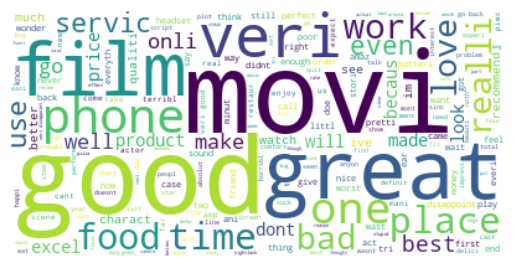

In [5]:
# Visualise word cloud
from wordcloud import WordCloud

# Generate the word cloud 
text_word_cloud = WordCloud(background_color="white").generate(X_train_stem.iloc[:,1].str.cat(sep=' '))

# Create a figure of the generated cloud
plt.imshow(text_word_cloud, interpolation='bilinear')  
plt.axis('off')

# Display the figure
plt.show()

In [6]:
## Get word frequency for the top 20 words in the training data

from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS

my_stop_words = ['the', 'and', 'it', 'is', 'this', 'was', 'to', 'of', 'in', 'for', 'that',
                 'my', 'are', 'be', 'as', 'place', 'one', 'if', 'film', 'movi', 'phone', 'food']

vect = CountVectorizer(max_features=1000,
                           ngram_range=(1, 1), 
                           stop_words=my_stop_words,
                           #min_df=0.002
                           )

# Fit training data
vect.fit(X_train_stem['text'])

# tranform and sum number of words
bag_of_words = vect.transform(X_train_stem['text'])
sum_of_words = bag_of_words.sum(axis=0)

# build word list with counts
word_freq = [(word, sum_of_words[0, idx]) for word, idx in vect.vocabulary_.items()]

# build a dataframe and sort
word_freq_df = pd.DataFrame(word_freq, columns = ['word', 'count'])
word_freq_df.sort_values(by=['count'], ascending=False, inplace=True)
common_20_words = word_freq_df.head(20)
common_20_words

,word,count
17,not,243
23,with,213
49,veri,203
165,good,184
7,on,176
153,you,163
225,great,163
97,but,159
18,have,159
68,so,142


In [7]:
## Get bigram frequency for the top 20 words in the training data

vect = CountVectorizer(max_features=200,
                           ngram_range=(2, 2), 
                           stop_words=my_stop_words)
    
# Fit training data
vect.fit(X_train_stem['text'])

# tranform and sum number of words
bag_of_words = vect.transform(X_train_stem['text'])
sum_of_words = bag_of_words.sum(axis=0)

# build word list with counts
word_freq = [(word, sum_of_words[0, idx]) for word, idx in vect.vocabulary_.items()]

# build a dataframe and sort
df = pd.DataFrame(word_freq, columns = ['word', 'count'])
df.sort_values(by=['count'], ascending=False, inplace=True)
df.head(20)

,word,count
97,veri good,25
183,go back,23
43,did not,20
129,have been,19
101,work great,17
29,at all,17
4,veri disappoint,15
112,an excel,15
0,doe not,14
74,better than,14


## Task 2 – Feature representation
There are many possible approaches to feature representation, transforming any possible natural language document (often represented as an ordered list of words which can be of variable length) into a feature vector xn of a standard length. As a data scientist, you should be able to work with any feature representation for your given task. In this assignment you need to learn about Bag-of-words feature representation which is a popular one in Natural language processing (NLP) and exploit it for constructing the input features and training your classifier.

### Get number of words feature

In [8]:
# Get number of words in each review
from nltk.tokenize import word_tokenize

def get_n_words(dataframe, column_name):
    
    # Tokenize each item in the review column
    word_tokens = [word_tokenize(review) for review in dataframe[column_name]]

    # Create an empty list to store the length of the reviews
    len_tokens = []

    # Iterate over the word_tokens list and determine the length of each item
    for i in range(len(word_tokens)):
        len_tokens.append(len(word_tokens[i]))

    # Create a new feature for the lengh of each review
    dataframe['n_words'] = len_tokens
    
get_n_words(X_train_stem, 'text')
get_n_words(X_test_stem, 'text')

X_train.head()

,website_name,text
0,amazon,Oh and I forgot to also mention the weird colo...
1,amazon,THAT one didn't work either.
2,amazon,Waste of 13 bucks.
3,amazon,"Product is useless, since it does not have eno..."
4,amazon,None of the three sizes they sent with the hea...


In [9]:
### 

In [10]:
# function to get bag of words representation of the review

def get_bow(train_df, test_df, column_name, ngram=(1, 1), max_features=500):
    
    # Build the vectorizer, specify max features and fit
    vect = CountVectorizer(max_features=max_features, 
                           ngram_range=ngram,
                           stop_words=my_stop_words
                           )
    
    # Fit only on training data
    vect.fit(train_df[column_name])

    # Transform the review
    train_vect = vect.transform(train_df[column_name])
    test_vect = vect.transform(test_df[column_name])

    # Create a DataFrame from the bow representation
    train_vect_df = pd.DataFrame(train_vect.toarray(), columns=vect.get_feature_names_out())
    test_vect_df = pd.DataFrame(test_vect.toarray(), columns=vect.get_feature_names_out())
    
    return train_vect_df, test_vect_df
    

In [11]:
def get_vect(train_df, test_df, column_name):
    
    # get unigram vectorize of datasets
    unigrams_train, unigrams_test = get_bow(train_df, test_df, column_name, (1,1), 3500)
    print(unigrams_train.shape)
    
    # get bigrams vect of datasets
    bigrams_train, bigrams_test = get_bow(train_df, test_df, column_name, (2,2), 500)
    print(bigrams_train.shape)
    
    # concat the unigram and bigram datasets
    train_vect_df = pd.concat([unigrams_train, bigrams_train], axis=1)
    test_vect_df = pd.concat([unigrams_test, bigrams_test], axis=1)
    
    # add number of words
    train_vect_df['n_words'] = train_df['n_words']
    test_vect_df['n_words'] = test_df['n_words']
    
    # return vect datasets
    return train_vect_df, test_vect_df

X_train_vect, X_test_vect = get_vect(X_train_stem, X_test_stem, 'text')

feature_names = X_train_vect.columns

print(X_train_vect.columns.equals(X_test_vect.columns))

(2400, 3500)
(2400, 500)
True


In [12]:
from sklearn.preprocessing import MinMaxScaler

#concat so data can be scaled together
data = pd.concat([X_train_vect, X_test_vect], axis=0)

# Scale the data
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

X_train_vect = data[:len(X_train_vect)]
X_test_vect = data[len(X_train_vect):]

# confirm shapes
print(X_train_vect.shape)
print(X_test_vect.shape)

(2400, 4001)
(600, 4001)


In [13]:
# add feature names back
X_train_vect = pd.DataFrame(X_train_vect, columns=feature_names)
X_test_vect = pd.DataFrame(X_test_vect, columns=feature_names)

X_train_vect.describe()

,abandon,abhor,abil,abl,abound,about,abov,abovepretti,abroad,absolut,...,you pay,you see,you should,you want,you will,you wont,your money,your time,zero star,n_words
count,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,...,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000
mean,0.000417,0.000417,0.001667,0.001667,0.000417,0.014583,0.002083,0.000417,0.000417,0.007917,...,0.001667,0.001250,0.001250,0.002083,0.001667,0.002500,0.004167,0.002500,0.001042,0.155628
std,0.020412,0.020412,0.040799,0.040799,0.020412,0.087791,0.045605,0.020412,0.020412,0.088641,...,0.040799,0.035341,0.035341,0.045605,0.040799,0.049948,0.064429,0.049948,0.026989,0.111528
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.072464
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.130435
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.217391
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.869565


## Task 3 – Classification and Evaluation (30%)

### Model Comparison

In [14]:
from sklearn.model_selection import cross_validate, StratifiedGroupKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
import time

# Model comparison
def get_model_scores(X, y, models, folds=5):
    
    # Set scores dataframe
    index = ['Accuracy', 'Precision', 'F1', 'Recall', 'AUC']
    scores = pd.DataFrame(index=index)
    
    # metrics to be calculated
    metrics = ['accuracy', 'precision', 'f1', 'recall', 'roc_auc']
    
    # Iterate over the models
    for model in models:
        
        # start time
        time1 = time.time()

        # fit the model and get metric scores
        score = cross_validate(model, X, y, cv=folds, scoring=metrics)
        acc = score['test_accuracy']
        pre = score['test_precision']
        f1 = score['test_f1']
        recall = score['test_recall']
        auc = score['test_roc_auc']
        
        # get the mean average across the folds and add scores to dataframe
        scores[str(model)] = [ acc.mean(), pre.mean(), f1.mean(), recall.mean(), auc.mean()]
        
        # calc time taken and print
        time2 = time.time()
        time_taken = time2 - time1
        print(str(model), 'completed in ', time_taken)
        
    return scores

# Models to be compared
models = [LogisticRegression(), 
          DecisionTreeClassifier(), 
          KNeighborsClassifier(), 
          GaussianNB(), 
          MultinomialNB()]

# Get model score dataframe
score_df = get_model_scores(X_train_vect, y_train, models, 5)
score_df

LogisticRegression() completed in  2.047612190246582
DecisionTreeClassifier() completed in  4.111622095108032
KNeighborsClassifier() completed in  1.759979009628296
GaussianNB() completed in  1.5139491558074951
MultinomialNB() completed in  0.5357849597930908


,LogisticRegression(),DecisionTreeClassifier(),KNeighborsClassifier(),GaussianNB(),MultinomialNB()
Accuracy,0.827083,0.750000,0.659167,0.736250,0.803333
Precision,0.828332,0.767068,0.611670,0.791133,0.812046
F1,0.826737,0.742067,0.724337,0.706607,0.800406
Recall,0.827500,0.720000,0.894167,0.645833,0.790833
AUC,0.891609,0.750000,0.752269,0.783359,0.877844


<h3> Best performing model is Logistic Regression</h3>

### Hyperparameter Tuning

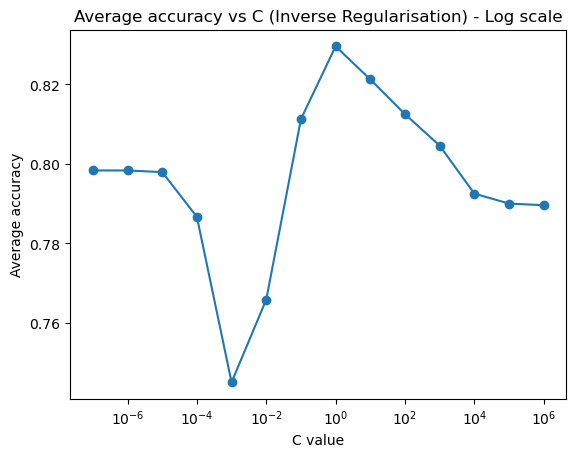

<Figure size 640x480 with 0 Axes>

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Create a stratified k-fold object
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=108)

# c values to tune
c_value = np.logspace(-7, 6, 14)

# result lists
ave_acc = []

# run log reg model for all 10 values of C
for c in c_value:
    # Create a logistic regression
    log_reg = LogisticRegression(C=c,
                                 max_iter=10000, 
                                 random_state=108
                                 )
    # save C value
    acc_values = []
    
    # Iterate over the folds
    for train_index, test_index in skf.split(X_train_vect, y_train):
        X_train_fold, X_test_fold = X_train_vect.values[train_index], X_train_vect.values[test_index]
        y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

        # Fit the model
        log_reg.fit(X_train_fold, y_train_fold)

        # Predict the labels
        y_predicted = log_reg.predict(X_test_fold)
        
        # Append the accuracy score to the list
        acc_values.append(accuracy_score(y_test_fold, y_predicted))
        
    # Append the average accuracy score to the list
    ave_acc.append(sum(acc_values)/len(acc_values))
    
# df of c value and average accuracy
c_vs_acc = pd.DataFrame({'c_value':c_value, 'average_accuracy':ave_acc})

# Plot the average accuracy vs c value
plt.plot(c_vs_acc['c_value'], c_vs_acc['average_accuracy'], '-o')
plt.xscale('log')
plt.xlabel('C value')
plt.ylabel('Average accuracy')
plt.title('Average accuracy vs C (Inverse Regularisation) - Log scale')

#plt.savefig('c_vs_acc.png')
plt.show()


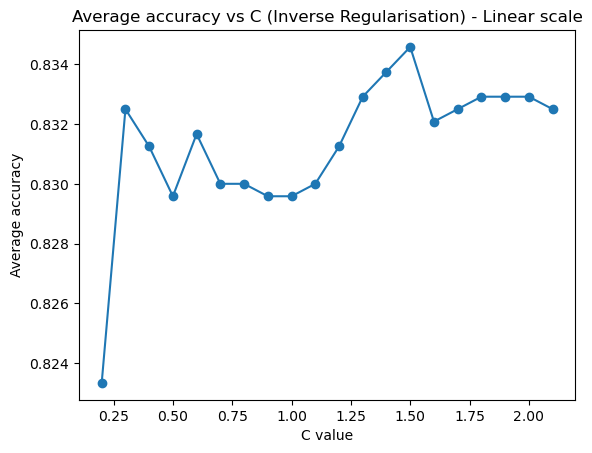

In [28]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Create a stratified k-fold object
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=108)

# c values to tune
c_value = np.arange(0.2, 2.2, 0.1)

# result lists
ave_acc = []

# run log reg model for all 10 values of C
for c in c_value:
    # Create a logistic regression
    log_reg = LogisticRegression(C=c,
                                 max_iter=10000,
                                 random_state=108
                                 )
    # save C value
    acc_values = []
    
    # Iterate over the folds
    for train_index, test_index in skf.split(X_train_vect, y_train):
        X_train_fold, X_test_fold = X_train_vect.values[train_index], X_train_vect.values[test_index]
        y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

        # Fit the model
        log_reg.fit(X_train_fold, y_train_fold)

        # Predict the labels
        y_predicted = log_reg.predict(X_test_fold)
        
        # Append the accuracy score to the list
        acc_values.append(accuracy_score(y_test_fold, y_predicted))
        
    # Append the average accuracy score to the list
    ave_acc.append(sum(acc_values)/len(acc_values))
    
# df of c value and average accuracy
c_vs_acc = pd.DataFrame({'c_value':c_value, 'average_accuracy':ave_acc})

# Plot the average accuracy vs c value
plt.plot(c_vs_acc['c_value'], c_vs_acc['average_accuracy'], '-o')
plt.xscale('linear')
plt.xlabel('C value')
plt.ylabel('Average accuracy')
plt.title('Average accuracy vs C (Inverse Regularisation) - Linear scale')

#plt.savefig('c_vs_acc_0-2.png')
plt.show()

In [17]:
# Get the best C value
best_c = c_vs_acc.loc[c_vs_acc['average_accuracy'].idxmax()]['c_value']


model = [LogisticRegression( C=best_c,
                             max_iter=1000,
                             )]

# get cross validation scores 
get_model_scores(X_train_vect, y_train, model, 5)

LogisticRegression(C=1.5000000000000004, max_iter=1000) completed in  2.2759580612182617


,"LogisticRegression(C=1.5000000000000004, max_iter=1000)"
Accuracy,0.827500
Precision,0.828155
F1,0.827154
Recall,0.828333
AUC,0.892332


### Run and Evaluate Model on Test Data

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer

# Get the best C value
best_c = c_vs_acc.loc[c_vs_acc['average_accuracy'].idxmax()]['c_value']

# Train a logistic regression
log_reg = LogisticRegression( C=best_c,
                             max_iter=1000,

                             )

log_reg.fit(X_train_vect, y_train)

# Predict the labels
y_pred = log_reg.predict(X_test_vect)

# Print the best_c
print('Best C value: ', best_c, '\n')

# Check overfitting
print('Accuracy on the training set: ', log_reg.score(X_train_vect, y_train), '\n')

# Print accuracy score and confusion matrix on test set
print('Accuracy on the test set: ', accuracy_score(y_test, y_pred), '\n')
print('Confusion matrix: \n',confusion_matrix(y_test, y_pred), '\n')

Best C value:  1.5000000000000004 

Accuracy on the training set:  0.9866666666666667 

Accuracy on the test set:  0.8366666666666667 

Confusion matrix: 
 [[267  33]
 [ 65 235]] 



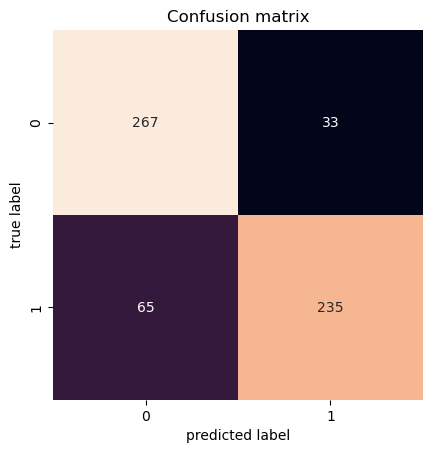

Accuracy:  0.8366666666666667
Precision:  0.8768656716417911
F1:  0.8274647887323944
Recall:  0.7833333333333333
ACU :  0.8366666666666667


In [19]:
## confusion matrix

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score, roc_auc_score

# get confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# turn confusion matrix in to heatmap visualisation
sns.heatmap(conf_matrix, square=True, annot=True, fmt='d', cbar=False)
plt.title('Confusion matrix')
plt.ylabel('true label')
plt.xlabel('predicted label')
plt.show()

# print metrics
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('F1: ', f1_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('ACU : ', roc_auc_score(y_test, y_pred))

In [20]:
# does it do better on longer sentences or shorter sentences?
results_df = pd.DataFrame(y_pred, columns=['y_pred'])
results_df['y_test'] = y_test
results_df['website'] = X_test['website_name']
results_df['n_words'] = X_test_stem['n_words']

results_df['correct'] = results_df['y_pred'] == results_df['y_test']
results_df['incorrect'] = ~results_df['correct']

results_df['text'] = X_test['text']

results_df

,y_pred,y_test,website,n_words,correct,incorrect,text
0,1,0,amazon,9,False,True,It only recognizes the Phone as its storage de...
1,0,0,amazon,6,True,False,Disappointing accessory from a good manufacturer.
2,0,0,amazon,30,True,False,The one big drawback of the MP3 player is that...
3,0,0,amazon,11,True,False,This particular model would not work with my M...
4,0,0,amazon,21,True,False,If the two were seperated by a mere 5+ ft I st...
...,...,...,...,...,...,...,...
595,1,1,yelp,5,True,False,Everything was fresh and delicious!
596,0,1,yelp,1,False,True,#NAME?
597,1,1,yelp,3,True,False,Pretty awesome place.
598,1,1,yelp,8,True,False,"The staff are great, the ambiance is great."


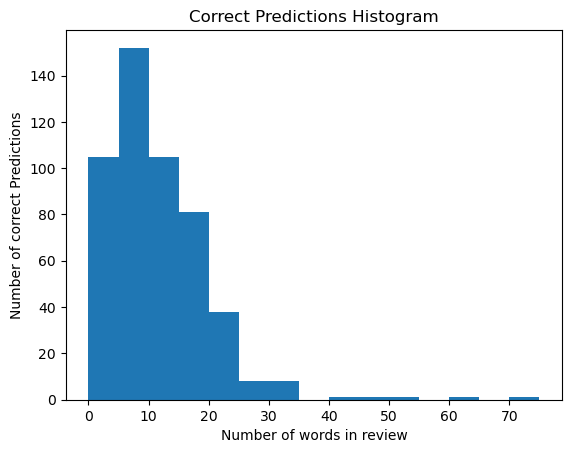

In [21]:
# does it do better on longer sentences or shorter sentences?
bins = np.arange(0, 80, 5)
plt.hist(results_df[results_df['correct'] == True].n_words, bins = bins)
plt.title('Correct Predictions Histogram')
plt.xlabel('Number of words in review')
plt.ylabel('Number of correct Predictions')
plt.show()

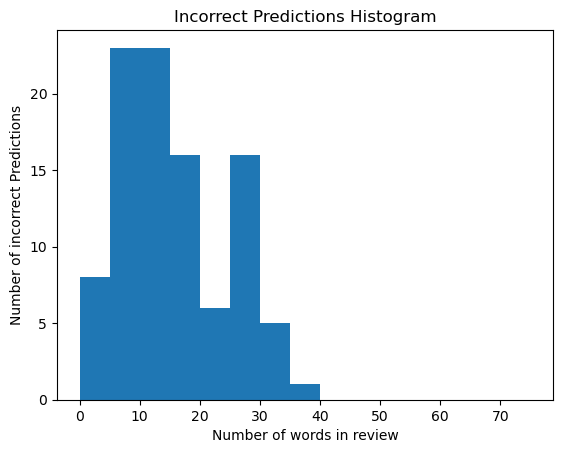

In [22]:
plt.hist(results_df[results_df['incorrect'] == True].n_words, bins = bins)
plt.title('Incorrect Predictions Histogram')
plt.xlabel('Number of words in review')
plt.ylabel('Number of incorrect Predictions')
plt.show()

         correct  incorrect
website                    
amazon       173         27
imdb         156         44
yelp         173         27


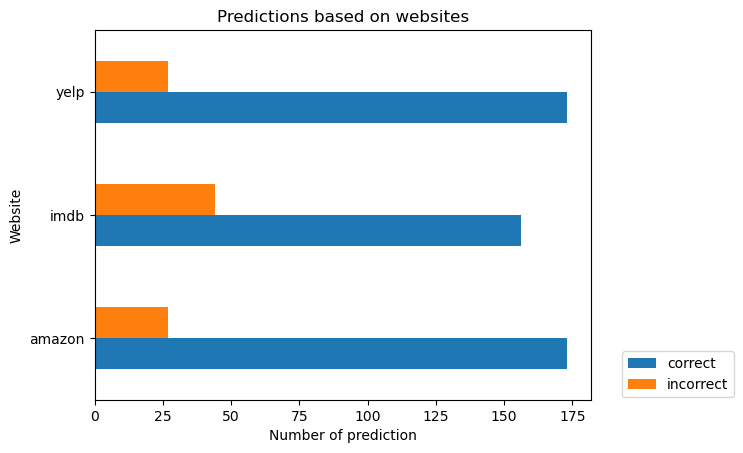

In [23]:
# does it do better on a particular kind of review (amazon or imdb)?
website = results_df.groupby('website')[['correct', 'incorrect']].sum()
print(website)
website.plot(kind='barh')
plt.title('Predictions based on websites')
plt.xlabel('Number of prediction')
plt.ylabel('Website')
plt.legend(bbox_to_anchor =(1.05, 0.15), ncol = 1)

In [24]:
# does it do better on sentences without negation words ("not", "didn't", "shouldn't", etc.)?

# add stemmed words to results_df
results_df[['not', 'didn', 'shouldn']] = X_test_vect[['not', 'didnt', 'shouldnt']]

# filter negation words out
results_df_wo_neg = results_df[(results_df['not'] == 0) & (results_df['didn'] == 0) & (results_df['didn'] == 0)]

# check scores
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Accuracy w-o neg: ', accuracy_score(results_df_wo_neg.y_test, results_df_wo_neg.y_pred))

print('\nPrecision: ', precision_score(y_test, y_pred))
print('Precision w-o neg: ', precision_score(results_df_wo_neg.y_test, results_df_wo_neg.y_pred))

print('\nConfusion Matrix :\n', confusion_matrix(y_test, y_pred))
print('\nConfusion Matrix :\n', confusion_matrix(results_df_wo_neg.y_test, results_df_wo_neg.y_pred))

Accuracy:  0.8366666666666667
Accuracy w-o neg:  0.835820895522388

Precision:  0.8768656716417911
Precision w-o neg:  0.8816793893129771

Confusion Matrix :
 [[267  33]
 [ 65 235]]

Confusion Matrix :
 [[217  31]
 [ 57 231]]


### Review samples

In [25]:
# get false positive samples
sample = results_df[(results_df['incorrect'] == True) & (results_df['y_test'] == 0)].sample(5, random_state=108, ignore_index=True)

for i in np.arange(0,5):
    print(sample.loc[i].text)


It defeats the purpose of a bluetooth headset.
It's this pandering to the audience that sabotages most of his films.  
But I recommend waiting for their future efforts, let this one go.  
The plot simply rumbles on like a machine, desperately depending on the addition of new scenes.  
However, my recent experience at this particular location was not so good.


In [26]:
# get false negative samples
sample = results_df[(results_df['incorrect'] == True) & (results_df['y_test'] == 1)].sample(5, random_state=108, ignore_index=True)

for i in np.arange(0,5):
    print(sample.loc[i].text)

Highly entertaining at all angles.  
One of the best mexican movies ever!, and one of the less understood, even by mexican themselves, no matter how identified the should have felt with it.  
No shifting, no bubbling, no peeling, not even a scratch, NOTHING!I couldn't be more happier with my new one for the Droid.
Of course the footage from the 70s was grainy, but that only enhanced the film.  
Later I found myself lost in the power of the film.  


0.8366666666666667


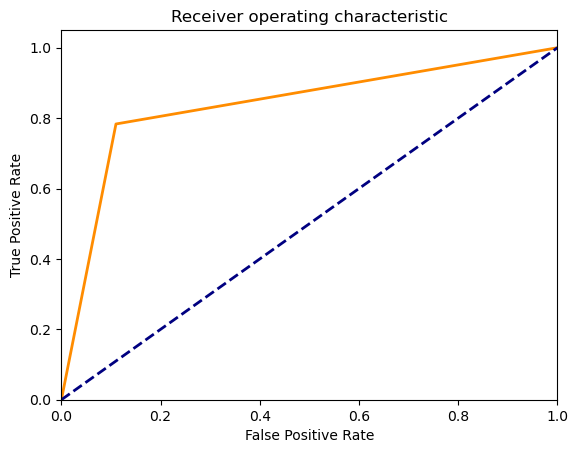

In [27]:
from sklearn.metrics import roc_curve, roc_auc_score

# auc roc curve
fpr1,  tpr1, thresholds1 = roc_curve(y_test, y_pred)

# auc_scores
auc_score1 = roc_auc_score(y_test, y_pred)
print(auc_score1)

# plot roc curve
plt.plot(fpr1, tpr1, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_score1)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')

plt.show()
